# Notebook IV - Modeling

In [225]:
# imports
import pandas as pd
import numpy as np

# modeling
import pmdarima as pmd
from pmdarima.utils import tsdisplay, plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# graphing
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

In [32]:
data = pd.read_csv('./cleaned_data/trips_cleaned_aggregated.csv')
data

,date,start_station_id,start_station_name,month,day,year,duration_minutes,trip_revenue,trip_count,day_of_week
0,2014-01-01,1002,6th & Navasota St.,1,1,2014,0.0,0.0,0.0,Wednesday
1,2014-01-02,1002,6th & Navasota St.,1,2,2014,0.0,0.0,0.0,Thursday
2,2014-01-03,1002,6th & Navasota St.,1,3,2014,0.0,0.0,0.0,Friday
3,2014-01-04,1002,6th & Navasota St.,1,4,2014,0.0,0.0,0.0,Saturday
4,2014-01-05,1002,6th & Navasota St.,1,5,2014,0.0,0.0,0.0,Sunday
...,...,...,...,...,...,...,...,...,...,...
43795,2015-12-27,9994,Red River @ LBJ Library,12,27,2015,0.0,0.0,0.0,Sunday
43796,2015-12-28,9994,Red River @ LBJ Library,12,28,2015,0.0,0.0,0.0,Monday
43797,2015-12-29,9994,Red River @ LBJ Library,12,29,2015,0.0,0.0,0.0,Tuesday
43798,2015-12-30,9994,Red River @ LBJ Library,12,30,2015,0.0,0.0,0.0,Wednesday


### 4a. Building a Sample SARIMA for `2nd & Congress`

To test drive the data, I am just going to start by building sample models using just 1 station, "2nd & Congress." For simplicity, I will assume that there are no drastic differences between the stations for now. As I previously mentioned, having additional information on the stations (such as type  dictated by location in Austin) may be useful variables in helping us distinguish between the stations further. However, for now, I will assume they are relatively homogenous and proceed accordingly.

My simple models will only have the date factored in, so I am omitting other predictors for now. In the future, I would be very interested in incorporating some of the weather metrics, as well as the `day_of_week` variable I made in Notebook 1.

In [204]:
data_test = data[data['start_station_name'] == '2nd & Congress'][['date','trip_revenue']]
data_test.set_index('date', inplace = True)
data_test

,trip_revenue
date,
2014-01-01,115.9
2014-01-02,61.0
2014-01-03,3.4
2014-01-04,9.2
2014-01-05,0.0
...,...
2015-12-27,0.0
2015-12-28,5.7
2015-12-29,55.8


#### Checking for Stationarity

A time-series is considered ***stationary*** if the mean and variance are **not** a function of time. We would prefer a time-series to be more stationary since this would imply that its mean, variance, and other characteristics remain relatively stable over time. This will allow for more accurate forecasting and reliable modeling. <br><br>
On top of plotting, I will also run a **Dickey-Fuller** test to check for stationarity.

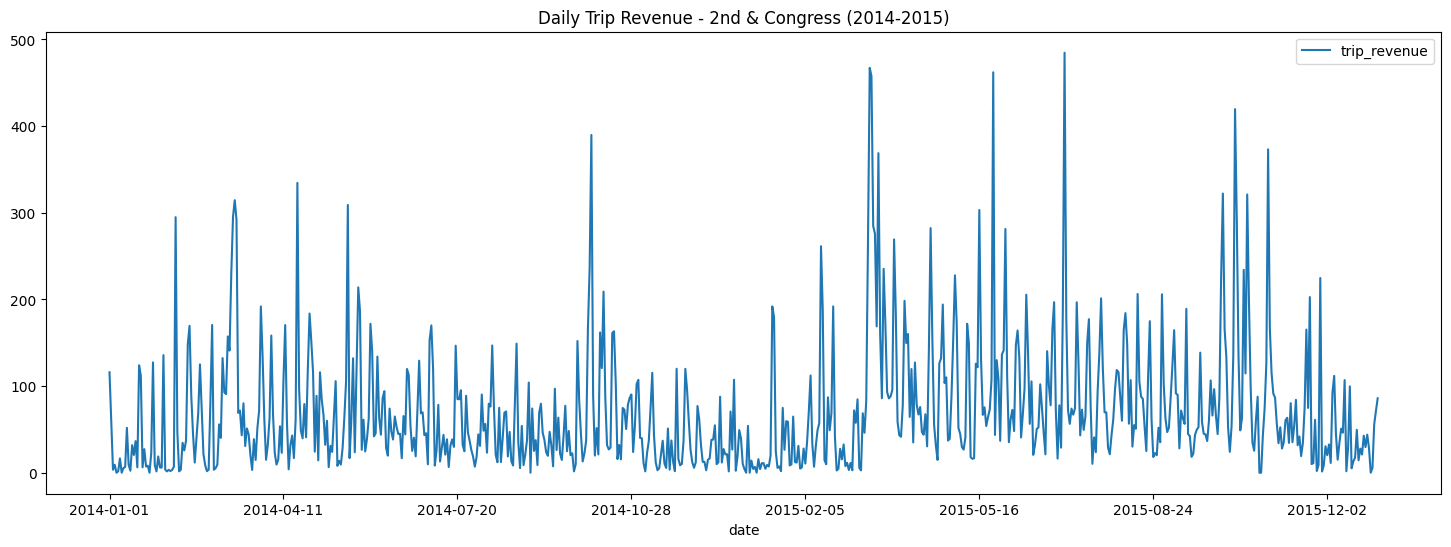

In [205]:
data_test.plot(figsize = (18,6))
plt.title('Daily Trip Revenue - 2nd & Congress (2014-2015)')
plt.savefig('./graphs/2nd&Congress_triprev.jpeg', dpi = 1080);

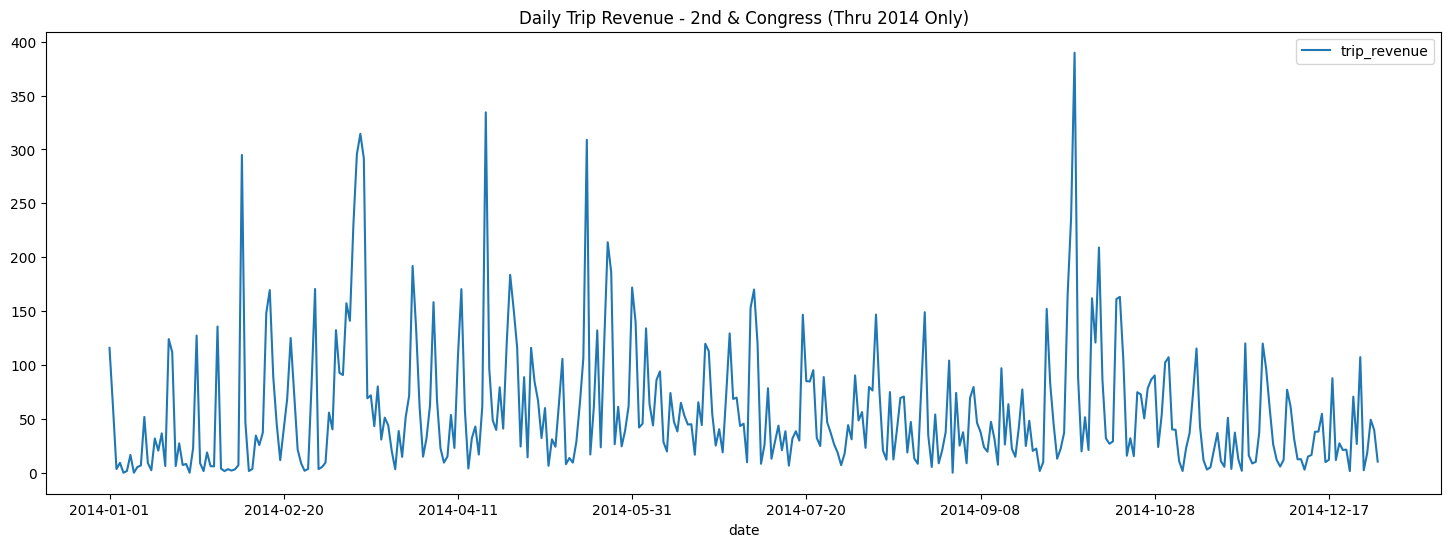

In [206]:
data_test.loc[:'2014-12-31'].plot(figsize = (18,6))
plt.title('Daily Trip Revenue - 2nd & Congress (Thru 2014 Only)')
plt.savefig('./graphs/2nd&Congress_triprev.jpeg', dpi = 1080);

The above data has very frequent spikes and drops. From visually examining, it appears that revenue data might be **cyclical** (pun intended) and seasonal by week. I'll factor this in when adjusting model parameters later.

In [207]:
# quick function to read contents of adfuller
def read_adfuller(adfuller_test):
    output = pd.Series(adfuller_test[0:3], index = ['Test Stat', 'P-Value', 'Lag Used'])
    return output

In [209]:
# let's call function & run adfuller
read_adfuller(adfuller(data_test['trip_revenue']))

Test Stat    -3.817852
P-Value       0.002730
Lag Used     20.000000
dtype: float64

The null hypothesis for Dickey-Fuller is that the time series is non-stationary. The alterate hypothesis is the time-series is stationary. <br><br> Since the p-value here is low (<0.005), we can reject the null hypothesis. We do not need to difference or detrend to make the time-series more stationary.

In [210]:
data_test

,trip_revenue
date,
2014-01-01,115.9
2014-01-02,61.0
2014-01-03,3.4
2014-01-04,9.2
2014-01-05,0.0
...,...
2015-12-27,0.0
2015-12-28,5.7
2015-12-29,55.8


I will run seasonal decompose to view how adjusting the period (seasonality) affects the smoothness of the trend.

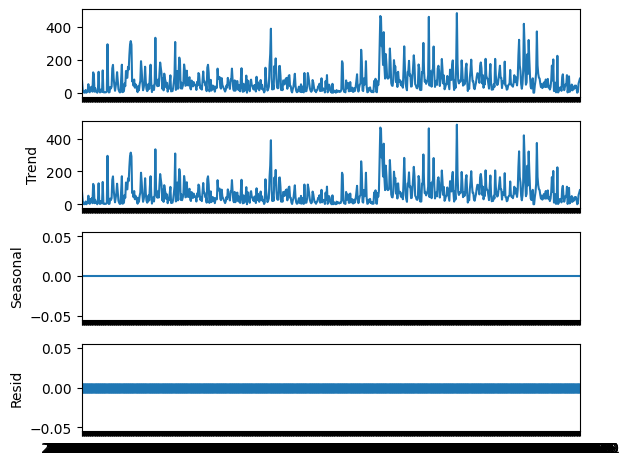

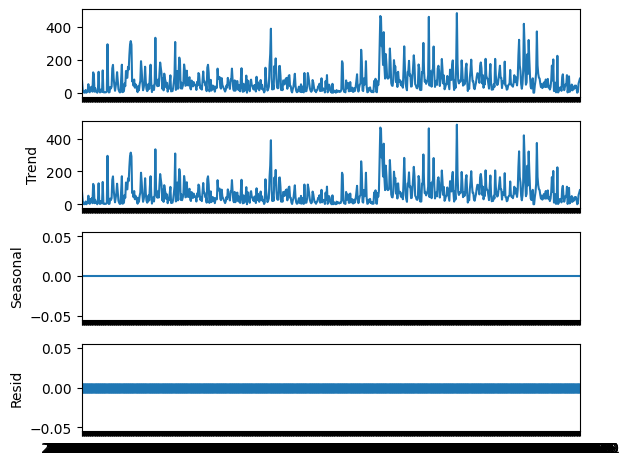

In [211]:
### period = 1 (annual, no seasonality)
seasonal_decompose(data_test, period = 1).plot()

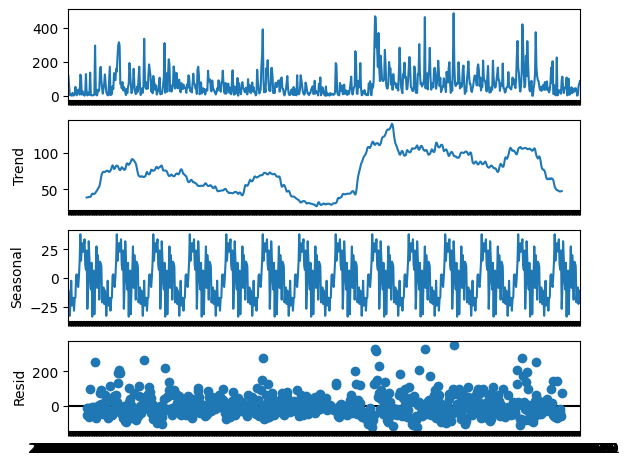

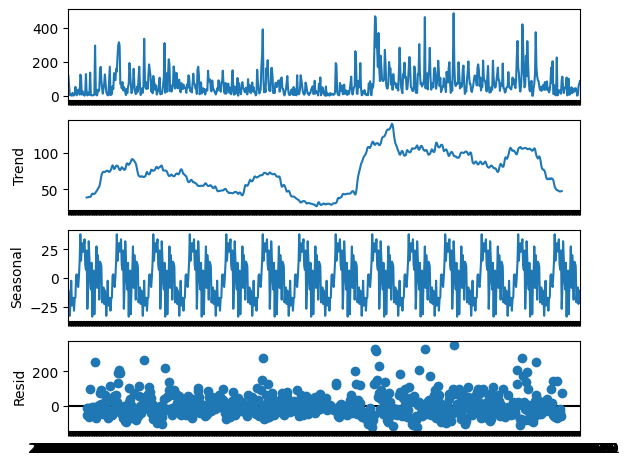

In [212]:
### period = 52, weekly
seasonal_decompose(data_test, period = 52).plot()

Setting the period to 52 creates a much smoother trend overall. This supports that the data is likely cyclical by week. We also saw some evidence of this in Notebook 3 when graphing average daily revenue by day of the week.

/opt/anaconda3/envs/sktimeenv/lib/python3.9/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


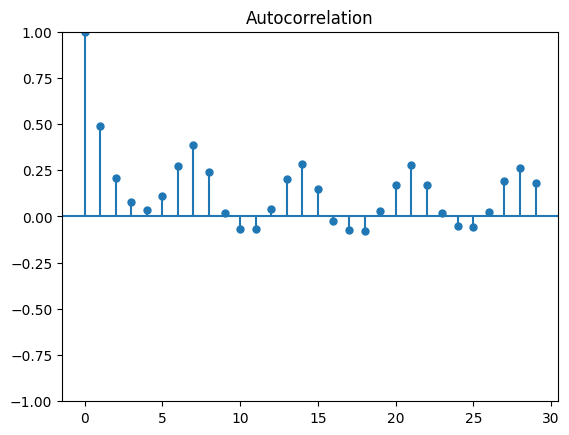

In [213]:
plot_acf(data_test)

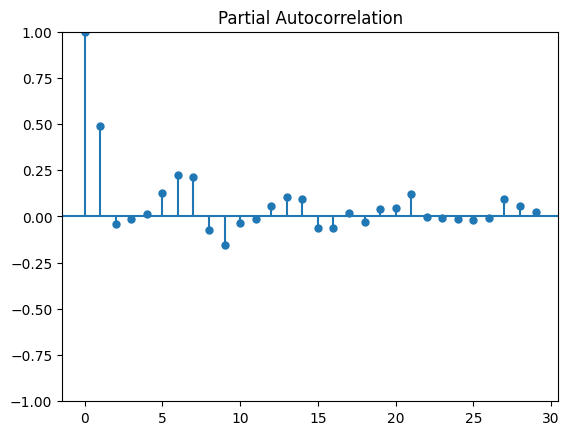

In [214]:
plot_pacf(data_test)

The ACF and PACF plots above lend credence to a weekly seasonality as well. There appears to be an up tick in the values of the autocorrelated points after every 7 points, followed by a downwards trend. This continues roughly after every 7th point. 

#### SARIMA Model
With the prior analysis, I believe there is a seasonal component to the bike-share data. <br>

I will proceed with building a simple SARIMA model with the prior analysis in mind.

In [215]:
# setting up train (2014 data)
train = data_test.loc[:'2014-12-31']
train

,trip_revenue
date,
2014-01-01,115.9
2014-01-02,61.0
2014-01-03,3.4
2014-01-04,9.2
2014-01-05,0.0
...,...
2014-12-27,2.3
2014-12-28,18.4
2014-12-29,49.2


In [216]:
# set up test to pick up where train left off (2015 data)
test = data_test.loc['2015-01-01':]
test

,trip_revenue
date,
2015-01-01,4.0
2015-01-02,0.0
2015-01-03,54.1
2015-01-04,0.0
2015-01-05,14.0
...,...
2015-12-27,0.0
2015-12-28,5.7
2015-12-29,55.8


In [219]:
# instantiating model
    # m = 52 (weekly)
model = pmd.auto_arima(train['trip_revenue'], m = 52, trace = True, seasonal = True)

/opt/anaconda3/envs/sktimeenv/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=3962.662, Time=14.86 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=4028.048, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3956.234, Time=5.16 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3963.338, Time=3.21 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=4267.116, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=3959.069, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=3956.317, Time=29.88 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=3957.082, Time=7.01 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=3956.829, Time=3.49 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=3958.340, Time=20.31 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=4018.818, Time=3.22 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=3957.763, Time=6.87 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=3957.802, Time=6.25 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=3962.682, Time=3.92 sec
 ARIMA(2,0,1)(1,

In [220]:
test['preds_sarima'] = model.predict(test.shape[0])

test.head()

/var/folders/99/p9vk8qnd3c7_117vsyvdk64w0000gn/T/ipykernel_17005/1629514578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['preds_sarima'] = model.predict(test.shape[0])


,trip_revenue,preds_sarima
date,,
2015-01-01,4.0,43.761187
2015-01-02,0.0,57.580261
2015-01-03,54.1,62.727906
2015-01-04,0.0,64.120282
2015-01-05,14.0,62.842561


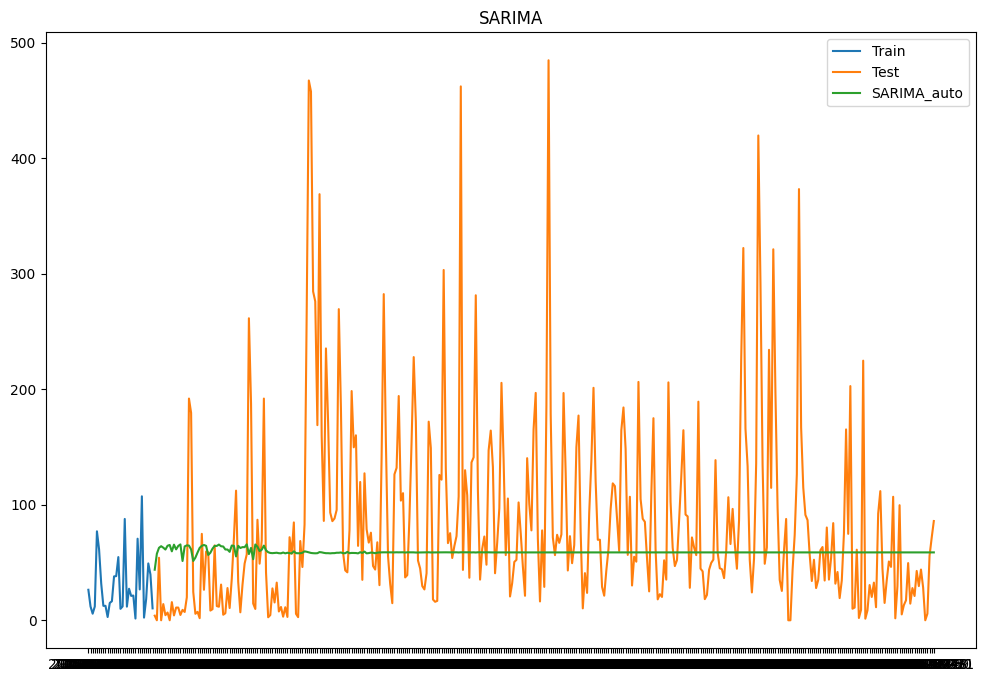

In [222]:
# quickly plotting graph to visually see the data
plt.figure(figsize = (12, 8))
plt.plot(train['trip_revenue'].loc['2014-12-01':], label = 'Train') # plot from December 2014 onwards
plt.plot(test['trip_revenue'], label = 'Test')
plt.plot(test['preds_sarima'], label = 'SARIMA_auto')
plt.legend(loc = 'best')
plt.title('SARIMA');

plt.savefig('./graphs/basic_sarima.jpeg', dpi = 1080)

Aside from the initial fluctuations in the beginning, the model soon begins to just predict roughly the average in the long term. The long term forecast is definitely not reliable since the true data contains many more pronounced peaks and valleys in daily revenue.

In [223]:
# measuring the RMSE
mean_squared_error(test['trip_revenue'],test['preds_sarima'], squared = False)

86.50024946370185

This first iteration of the model is not exceptionally strong. The RMSE is quite high with respect to the magnitude of possible values in our data. The RMSE tells us roughly the average gap between predicted and true values. <br><br>

Additionally, the auto_arima model's best pick for parameters does not quite match our prior analysis. Per the function, the best model here is :`ARIMA(1,0,0)(1,0,0)` <br> In the next iteration, I will manually adjust the values for P, D, Q to account for seasonal differencing and differencing the time-series.

---
---
### 4b. Building SARIMA with Seasonal Differencing & Log Transforming Revenue

Before proceeding, I want to check the distribution of revenue. It's possible that the data is skewed (likely to the right), and this is causing greater difficulty in predicting values.

Skew: 2.196650102898898


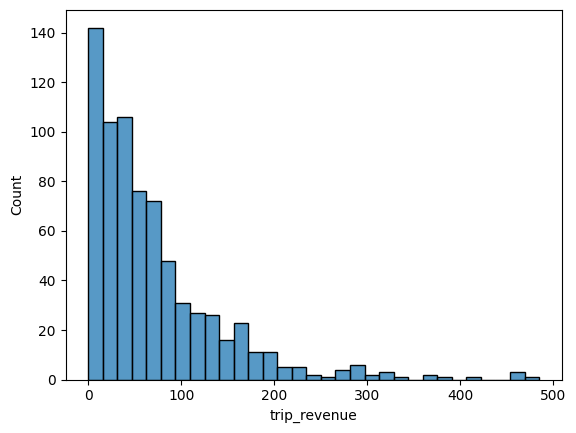

In [233]:
# plot dist of revenue
sns.histplot(data = data_test['trip_revenue'])
print(f"Skew: {data_test['trip_revenue'].skew()}")

As expected, ***the right skew is strong with this one***. The skew is greater than 2, so there is a very strong degree of skewness. Let's view the distribution after log transforming the revenue. 

In [227]:
# log transform the trip revenue --> use log1p transformation (accounts for days with 0 revenue)
data_test['log_revenue'] = np.log1p(data_test['trip_revenue'])

In [228]:
data_test

,trip_revenue,log_revenue
date,,
2014-01-01,115.9,4.761319
2014-01-02,61.0,4.127134
2014-01-03,3.4,1.481605
2014-01-04,9.2,2.322388
2014-01-05,0.0,0.000000
...,...,...
2015-12-27,0.0,0.000000
2015-12-28,5.7,1.902108
2015-12-29,55.8,4.039536


Skew: -0.7583750689565116


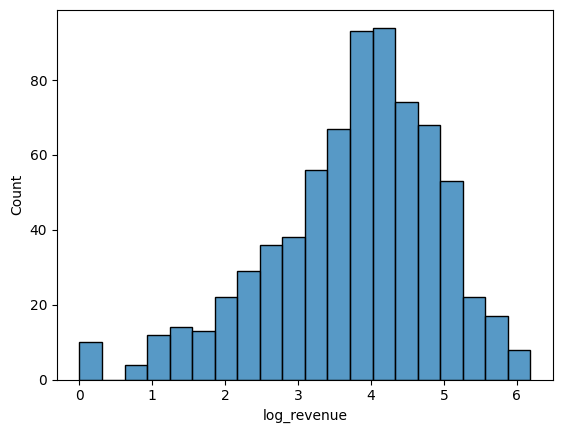

In [231]:
# plot dist of log(revenue)
sns.histplot(data = data_test['log_revenue'])
print(f"Skew: {data_test['log_revenue'].skew()}")

After log transforming, there is still a *moderate* left skew as indicated by both the distribution and the -0.76 measure of skew. However, it is still more normalized than its previous form. I will use the log transformed revenue for modeling purposes, and apply exponentiation to predicted values at the end.

/opt/anaconda3/envs/sktimeenv/lib/python3.9/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


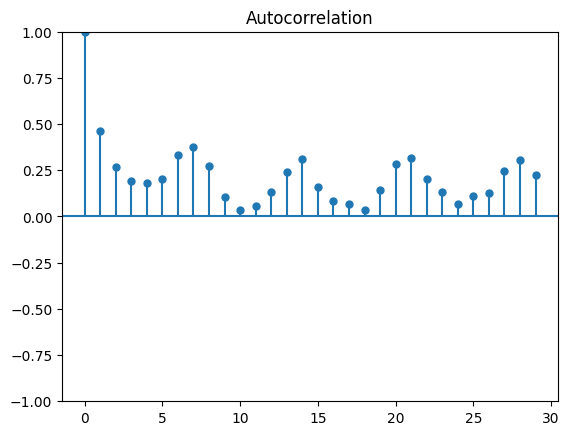

In [235]:
# checking weekly trend based on acf
plot_acf(data_test['log_revenue'])

The autocorrelation function here is similar to pre-log revenue. We will keep the same value for the 'm' parameter in the model. Since I am doing this chronologically, I will overrwrite the train/test and other relevant variables to track data for the current model.

In [238]:
# train on log
# setting up train (2014 data)
train = data_test.loc[:'2014-12-31'][['log_revenue']]
train

,log_revenue
date,
2014-01-01,4.761319
2014-01-02,4.127134
2014-01-03,1.481605
2014-01-04,2.322388
2014-01-05,0.000000
...,...
2014-12-27,1.193922
2014-12-28,2.965273
2014-12-29,3.916015


In [239]:
# test on log
test = data_test.loc['2015-01-01':][['log_revenue']]
test

,log_revenue
date,
2015-01-01,1.609438
2015-01-02,0.000000
2015-01-03,4.009150
2015-01-04,0.000000
2015-01-05,2.708050
...,...
2015-12-27,0.000000
2015-12-28,1.902108
2015-12-29,4.039536


For this model, I will specify `d = 0` explicity, along with `D = 1`. This will force auto_arima to factor in seasonal differencing and the order for differencing the time-series. I have chosen `d = 0` since the ADFuller test before supported that the time-series is already stationary. Therefore, we do not need to ensure stationarity. <br>

I studied the documentation and the parameters of this model to better understand how to improve it as well. Please refer to this helpful source.
[Source: https://alkaline-ml.com/pmdarima/tips_and_tricks.html#understand-p-d-and-q](https://alkaline-ml.com/pmdarima/tips_and_tricks.html#understand-p-d-and-q) 

In [192]:
# instantiating model
# d = 0 --> data already stationary per ADFuller test
# D = 1
model_2 = pmd.auto_arima(train['log_revenue'], m = 52, D = 1, d = 0, trace = True, seasonal = True,)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[52] intercept   : AIC=inf, Time=65.77 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1194.761, Time=0.37 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=1057.580, Time=6.41 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=9.78 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1193.043, Time=0.32 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=1136.162, Time=1.06 sec
 ARIMA(1,0,0)(2,1,0)[52] intercept   : AIC=1044.530, Time=19.52 sec
 ARIMA(1,0,0)(2,1,1)[52] intercept   : AIC=inf, Time=72.25 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=13.08 sec
 ARIMA(0,0,0)(2,1,0)[52] intercept   : AIC=1095.247, Time=16.14 sec
 ARIMA(2,0,0)(2,1,0)[52] intercept   : AIC=1044.893, Time=22.80 sec
 ARIMA(1,0,1)(2,1,0)[52] intercept   : AIC=1044.426, Time=38.80 sec
 ARIMA(1,0,1)(1,1,0)[52] intercept   : AIC=1057.781, Time=10.95 sec
 ARIMA(1,0,1)(2,1,1)[52] intercept   : AIC=1043.499, Time=96.86 sec
 ARIMA(1,0,1)(1,1,1)[52] inter

In [193]:
# log predictions
test['log_preds_sarima'] = model_2.predict(test.shape[0])

test.head()

,log_revenue,log_preds_sarima
date,,
2015-01-01,1.609438,3.173093
2015-01-02,0.000000,2.826400
2015-01-03,4.009150,2.484898
2015-01-04,0.000000,3.410319
2015-01-05,2.708050,2.929764


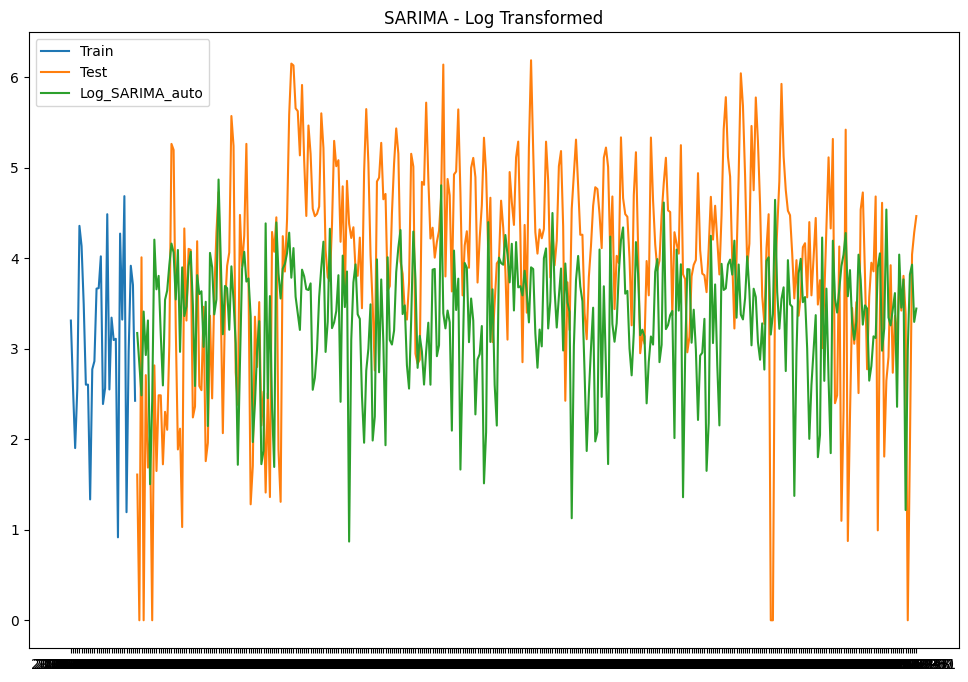

In [194]:
# quickly plotting graph to visually see the data
plt.figure(figsize = (12, 8))
plt.plot(train['log_revenue'].loc['2014-12-01':], label = 'Train') # plot from December 2014 onwards
plt.plot(test['log_revenue'], label = 'Test')
plt.plot(test['log_preds_sarima'], label = 'Log_SARIMA_auto')
plt.legend(loc = 'best')
plt.title('SARIMA - Log Transformed');

In [195]:
mean_squared_error(test['log_revenue'], test['log_preds_sarima'], squared = False)

1.424036705338341

This model is considerably better! The model has relatively captured the seasonality and rough trend of the data in 2014. Although it still isn't quite hitting the magnitude of some of the shocks (surges and crashes) in revenue, it is overall a much stronger forecast than the previous model. <br><br> Let's observe the model's forecast on the exponenitated data below:.

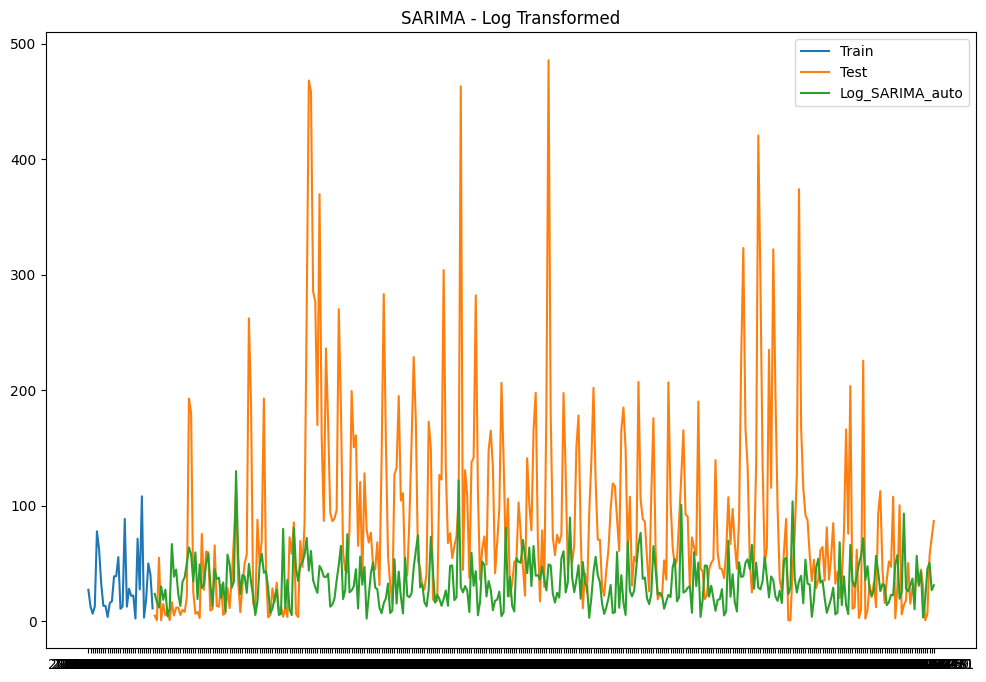

In [202]:
# quickly plotting graph to visually see the data

# apply np.exp() to values to convert from log!
plt.figure(figsize = (12, 8))
plt.plot(np.exp(train['log_revenue'].loc['2014-12-01':]), label = 'Train') # plot from December 2014 onwards
plt.plot(np.exp(test['log_revenue']), label = 'Test')
plt.plot(np.exp(test['log_preds_sarima']), label = 'Log_SARIMA_auto')
plt.legend(loc = 'best')
plt.title('SARIMA - Log Transformed');

Again, I would still say the forecast is much more reliable than the previous model. I would love to discuss how to make this model stronger and improve precision to accurately predict the surges and crashes in daily revenue. <br><br> **My overall methodology will be the same going forward, and I will assume the same parameters will apply to the rest of the stations due to time and hardware limitations**. The current best model on only half the available data took roughly 45 minutes for my computer to run. As a result, I will proceed with the same model parameters below for the remainder of my stations.

`Best model:  ARIMA(1,0,1)(2,1,1)[52]`          
`Total fit time: 2743.335 seconds`
- p = 1, P = 2
- d = 0, D = 1 
- q = 1, Q = 1
- period = 52 (weekly)

#### For the Future:
1. Run separate auto_arimas for each station to search for separate metrics
2. Incorporate exogenous variables

#### FINAL STEPS: 
For this test run, I utilized the 2014 data to train the model, and the 2015 data for testing. However, for the remainder of the models for each station, I will use both years to train and generate predictions for 2016. <br><br> Finally, I will pull the predictions for the relevant dates for my 10 stations and populate the predictions file.